In [1]:
"""
Class Name    : CS6140 Machine Learning 
Session       : Fall 2023 (Seattle)
Author        : Team B - Shiang Jin Chin
Last Update   : 12/17/2023
Description   : Contains all required code to run lightGBM 
"""
# %% [markdown]
# Instruction for use: Download the train.csv file from https://www.kaggle.com/competitions/optiver-trading-at-the-close/data.
# Place it in a directory, pass the directory path to the read_data function
#
# For lightGBM, option of pip install
# https://www.geeksforgeeks.org/how-to-install-lightgbm-on-windows/
#
# Or build the binaries for GPU, I used following guide from window
# https://lightgbm.readthedocs.io/en/latest/Installation-Guide.html#id18
# If you use cpu, then the device type should be set to cpu.
#
# All required import statement
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import time as time
import os
import gc

from sklearn import set_config
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from lightgbm import LGBMRegressor
import lightgbm as lgb
import optuna
from optuna.integration import LightGBMPruningCallback
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization.matplotlib import plot_optimization_history
# Common setting used
pd.set_option('display.max_rows', 100)
set_config(transform_output='pandas')
pd.options.mode.chained_assignment = None
seed = 42
tss = TimeSeriesSplit(10)
kf = KFold(n_splits=10)
data_path = "D:/OneDrive/NEU/CS6140/optiver-trading-at-the-close"

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 Part 1 - Preprocessing

 Prepare the functions required

In [2]:
dtypes = {
    'stock_id': np.uint8,
    'date_id': np.uint16,
    'seconds_in_bucket': np.uint16,
    'imbalance_buy_sell_flag': np.int8,
    'time_id': np.uint16,
}


def scale_data(X):
    """scale the data using standard scaler

    Args:
        X (dataframe): raw data to be scaled

    Returns:
        scaled_X (dataframe): data with selected columns scaled
    """
    scaler = StandardScaler()
    # Select columns to scale
    numerical = ['imbalance_size', 'reference_price', 'matched_size',
                 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size']
    # print(numerical)
    scaled_X = X.copy(deep=True)
    scaled_X.loc[:, numerical] = scaler.fit_transform(X.loc[:, numerical])
    return scaled_X


def read_data(data_path, drop_features=[], apply_scale=False, process_na=0):
    """Read the data from the train csv files, split them into the x (features) and y(target)
    default will drop row_id, time_id

    Args:
        data_path (str): absolute save path for the train and test data set 
        drop_features (list[str]) : list of additional features to drop
        apply_scale (bool, optional) : whether to apply standard scaler to the data, default is False
        process_na (int, optional) : option to deal with na, 0 = do nothing, 1 = fill 0 , 2 = drop

    Returns:
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
    """
    # Load data from the save path, 'row_id' and 'time_id' has no used during initial run, these are dropped
    train = pd.read_csv(f'{data_path}/train.csv',
                        dtype=dtypes).drop(['row_id', 'time_id'], axis=1)
    train.drop(drop_features, axis=1, inplace=True)
    # Check the data set
    train.info()
    print(train.head())
    gc.collect()

    # split data into X and y
    X = train[~train.target.isna()]
    if process_na == 1:
        X.fillna(0, inplace=True)
    elif process_na == 2:
        X.dropna(inplace=True)
    if apply_scale:
        X = scale_data(X)

    y = X.pop('target')

    # Check the data set
    print("after split")
    X.info()
    print(X.head())
    return X, y


def cross_validation(model,  X, y, cv=kf, saving=False, save_path=None, apply_pca=False, label='LightGBM'):
    """cross validation function

    Args:
        model (model): customized lightGBM model
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        cv (split, optional): split for the cross validation. Defaults to kfold.
        saving (bool, optional): whether you want to save your model, default is False
        save_path (str, optional) : target directory to save the model, defauls is None
        apply_pca (bool, optional) : whether to apply PCA, default is False
        label (str, optional): special label. Defaults to LightGBM.

    Returns:
        model: best model trained
    """
    # Build the save path if not exist
    if saving and save_path != None and not os.path.exists(save_path):
        os.makedirs(save_path)

    # initiate score lists and variables to store best results
    train_scores, val_scores = [], []
    best_model = None
    best_model_train_score = 0
    best_val_score = 0
    best_fold = 0

    # training model, for the cross validation split
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):

        model = clone(model)

        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        # Add PCA processing
        # I use all components, as main purpose is to aid in decision boundary
        if apply_pca:
            pca = PCA()
            pca.fit(X_train)
            pca.fit(X_val)

        # train model
        model.fit(X_train, y_train)

        # Save the model
        if saving:
            joblib.dump(model, f'./{save_path}/{label}_{fold}.model')

        # make predictions on training and validation set
        train_preds = model.predict(X_train)
        val_preds = model.predict(X_val)

        # evaluate model for a fold using MAE
        train_score = mean_absolute_error(y_train, train_preds)
        val_score = mean_absolute_error(y_val, val_preds)

        # Update best model
        if best_val_score == 0 or val_score < best_val_score:
            best_val_score = val_score
            best_model_train_score = train_score
            best_model = model
            best_fold = fold

        # append model score for a fold to list
        train_scores.append(train_score)
        val_scores.append(val_score)

    # Wrap up after the end of cross validation loop
    # This line print the average
    print(f'Val Score: {np.mean(val_scores):.5f} ± {np.std(val_scores):.5f} | Train Score: {np.mean(train_scores):.5f} ± {np.std(train_scores):.5f} | {label}')
    # Print best model score
    for fold in range(len(val_scores)):
        print(
            f'fold:{fold}, Val Score: {val_scores[fold]}, Train Score: {train_scores[fold]}')
    print(
        f'Best validation score: {best_val_score}, associated train score: {best_model_train_score}, fold:{best_fold}')
    # Save the best model and return
    if saving:
        joblib.dump(best_model, f'./{save_path}/best_model.model')
    return best_model


def plot_feature_importance(trained_model):
    """Small helper function to print the feature importance value

    Args:
        trained_model (model): trained LightGBM model
    """
    print(trained_model)
    lgb.plot_importance(trained_model, importance_type="gain", figsize=(
        7, 8), precision=0, title="LightGBM Feature Importance (Gain)")
    plt.show()
    lgb.plot_importance(trained_model, importance_type="split", figsize=(
        7, 8), precision=0, title="LightGBM Feature Importance (Split)")
    plt.show()

 First read the data

In [3]:
X, y = read_data(data_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

 Part 1 - First run, you can switch between gpu (need lightGBM built for gpu) or cpu
 Note for cpu it took about 100s, for gpu it is about 94s

 You can also try different cross-validation method, tss (time series split) or
 kf (kfold) , here we use tss, later code we will use kfold

 If you want to save the model , look up at the cross_validation args to input
 the save path, and turn the saving option on

Val Score: 6.47654 ± 0.54014 | Train Score: 6.14128 ± 0.42522 | LightGBM
fold:0, Val Score: 5.945709710185909, Train Score: 5.153227278977888
fold:1, Val Score: 7.323264515897156, Train Score: 5.503533048025268
fold:2, Val Score: 7.199841444897624, Train Score: 6.0893480522807595
fold:3, Val Score: 7.2346164332206335, Train Score: 6.292051635755668
fold:4, Val Score: 6.165380390988582, Train Score: 6.475964154868446
fold:5, Val Score: 6.045571658336207, Train Score: 6.4211332486247095
fold:6, Val Score: 6.56262981732713, Train Score: 6.366759202046237
fold:7, Val Score: 6.324487658640888, Train Score: 6.38932190405077
fold:8, Val Score: 6.078616172981801, Train Score: 6.379328740518991
fold:9, Val Score: 5.8853001193858905, Train Score: 6.3421756088725365
Best validation score: 5.8853001193858905, associated train score: 6.3421756088725365, fold:9
training time took = 95 seconds
LGBMRegressor(device_type='gpu', objective='mse', random_state=42, verbosity=0)


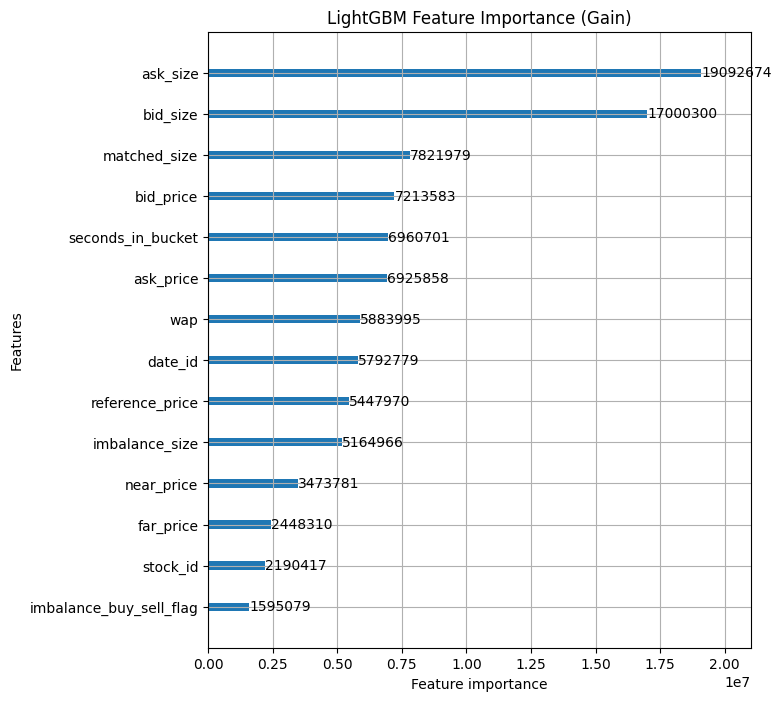

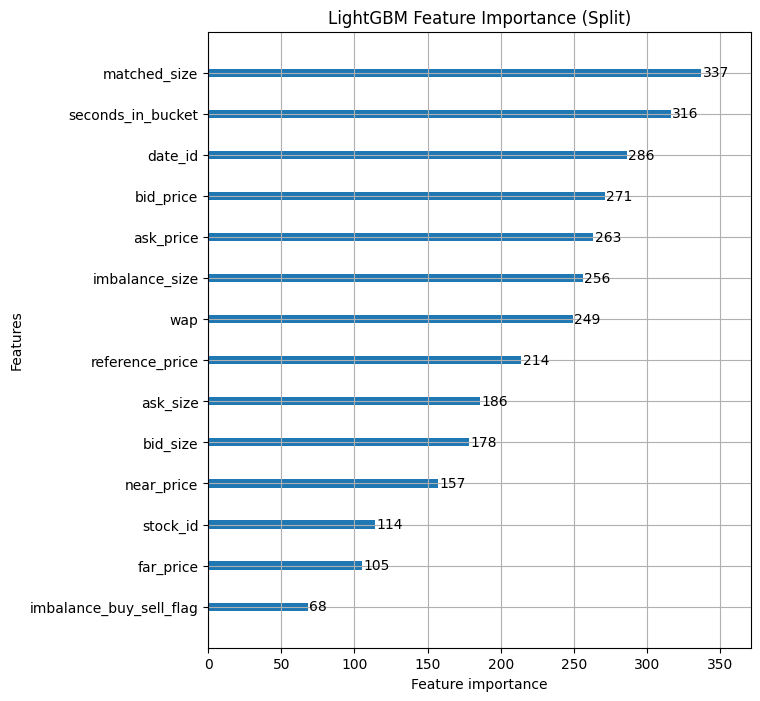

In [4]:
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

start = time.time()
best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=tss
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

# Plot the feature importance for the best model
plot_feature_importance(best_model)

 Part 1 - Second run, Now we want to try the effect of standardscaler().
 Read the data using scaled function, and run the model.
 Should take about 111 s with GPU

In [5]:
start = time.time()
X, y = read_data(data_path, apply_scale=True)
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    label='LightGBM_scaled'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')
# plot_feature_importance(best_model)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

 Part 1 - Third run, Now we want to try the effect of PCA().
 We need to modify the read data function to clean up the NaN value.
 And modify the cross_validation function to apply PCA() after the split
 First try with fillna with 0, It took about 150-200s

In [6]:
start = time.time()
# X, y = read_data(data_path, process_na=1)

# Different na processing, this time drop all na, should be faster
X, y = read_data(data_path, process_na=2)
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    apply_pca=True,
    label='LightGBM_pca'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

 Part 2 - Perform Experiments with Feature Engineering

 First define additional functions required

In [7]:
def add_derivatives(data_raw, derivative_targets):
    """add the first and second derivatives for target

    Args:
        data_raw (dataframe): raw training data
        derivative_targets (list[str]): list of derivate targets

    Returns:
        dataframe: processed raw data
    """
    # sort by stock_id so we can get next 10 seconds movement
    data_raw.sort_values(by=['stock_id', 'time_id'], inplace=True)
    for target in derivative_targets:
        if target not in data_raw.columns:
            continue
        data_raw[f'first_derivative_{target}'] = data_raw['reference_price'] - \
            data_raw['reference_price'].shift(1)
        data_raw[f'first_derivative_{target}'] = data_raw.apply(
            lambda x: 0 if x['seconds_in_bucket'] == 0 else x[f'first_derivative_{target}'], axis=1)
        data_raw[f'sec_derivative_{target}'] = data_raw[f'first_derivative_{target}'] - \
            data_raw[f'first_derivative_{target}'].shift(1)
        data_raw[f'sec_derivative_{target}'] = data_raw.apply(
            lambda x: 0 if x['seconds_in_bucket'] <= 10 else x[f'sec_derivative_{target}'], axis=1)

    # sort the data back
    data_raw.sort_values(by=['time_id', 'stock_id'], inplace=True)
    return data_raw


def imbalance_calculator(x):
    """calculate the imbalance features

    Args:
        x (dataframe): raw training data

    Returns:
        dataframe: processed raw data
    """
    x_copy = x.copy()

    x_copy['imb_s1'] = x.eval('(bid_size - ask_size) / (bid_size + ask_size)')
    x_copy['imb_s2'] = x.eval(
        '(imbalance_size - matched_size) / (matched_size + imbalance_size)')

    prices = ['reference_price', 'far_price',
              'near_price', 'ask_price', 'bid_price', 'wap']

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            if i > j:
                x_copy[f'{a}_{b}_imb'] = x.eval(f'({a} - {b}) / ({a} + {b})')

    for i, a in enumerate(prices):
        for j, b in enumerate(prices):
            for k, c in enumerate(prices):
                if i > j and j > k:
                    max_ = x[[a, b, c]].max(axis=1)
                    min_ = x[[a, b, c]].min(axis=1)
                    mid_ = x[[a, b, c]].sum(axis=1)-min_-max_

                    x_copy[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)

    return x_copy


def read_data_feature_engineering(data_path, drop_features=[], process_na=0, apply_derivative=False, derivative_targets=[], apply_imb=False):
    """Read the data from the train csv files, split them into the x (features) and y(target)

    Args:
        data_path (str): save path of the data
        drop_features (list[str]) : list of additional features to drop
        process_na (int, optional) : option to deal with na, 0 = do nothing, 1 = fill 0 , 2 = drop
        apply_derivative (bool, optional): _description_. Defaults to False.
        derivative_targets (list, optional): _description_. Defaults to [].
        apply_imb (bool, optional): _description_. Defaults to False.

    Returns:
        dataframe: X (dependent variables)
        dataframe: y (target)
    """
    # Load data from the save path
    train = pd.read_csv(f'{data_path}/train.csv',
                        dtype=dtypes)
    train.drop(drop_features, axis=1, inplace=True)

    # derivative is na sensitive, we need to apply it before any operation on na
    if apply_derivative:
        train = add_derivatives(train, derivative_targets)
    train.drop(['row_id', 'time_id'], axis=1, inplace=True)

    # Check the data set
    train.info()
    print(train.head())
    print(train.tail())
    gc.collect()

    # split data into X and y
    X = train[~train.target.isna()]
    if process_na == 1:
        X.fillna(0, inplace=True)
    elif process_na == 2:
        X.dropna(inplace=True)
    if apply_imb:
        X = imbalance_calculator(X)
    y = X.pop('target')

    X.info()
    print(X.head())
    return X, y

 Part2 - First run, Start with dropping four least important feature
 Should take about 140s

In [8]:
start = time.time()
X, y = read_data(data_path, drop_features=['near_price', 'stock_id', 'far_price',
                                           'imbalance_buy_sell_flag'])
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    label='LightGBM_feature_1'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 11 columns):
 #   Column             Dtype  
---  ------             -----  
 0   date_id            uint16 
 1   seconds_in_bucket  uint16 
 2   imbalance_size     float64
 3   reference_price    float64
 4   matched_size       float64
 5   bid_price          float64
 6   bid_size           float64
 7   ask_price          float64
 8   ask_size           float64
 9   wap                float64
 10  target             float64
dtypes: float64(9), uint16(2)
memory usage: 379.6 MB
   date_id  seconds_in_bucket  imbalance_size  reference_price  matched_size  \
0        0                  0      3180602.69         0.999812   13380276.64   
1        0                  0       166603.91         0.999896    1642214.25   
2        0                  0       302879.87         0.999561    1819368.03   
3        0                  0     11917682.27         1.000171   18389745.62   
4        0        

 Part2 - Second run, perform derivatives

In [9]:
start = time.time()

# This will take longer, about 250s
X, y = read_data_feature_engineering(
    data_path, apply_derivative=True, derivative_targets=['reference_price'])

# More derivative targets, warning, this could take about 15 minutes
# X, y = read_data_feature_engineering(data_path, apply_derivative=True,
#                                     derivative_targets=['ask_size', 'bid_size', 'matched_size',
#                                                         'bid_price', 'ask_price', 'wap', 'reference_price', 'imbalance_size'])
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    label='LightGBM_feature_2'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

<class 'pandas.core.frame.DataFrame'>
Index: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   stock_id                          uint8  
 1   date_id                           uint16 
 2   seconds_in_bucket                 uint16 
 3   imbalance_size                    float64
 4   imbalance_buy_sell_flag           int8   
 5   reference_price                   float64
 6   matched_size                      float64
 7   far_price                         float64
 8   near_price                        float64
 9   bid_price                         float64
 10  bid_size                          float64
 11  ask_price                         float64
 12  ask_size                          float64
 13  wap                               float64
 14  target                            float64
 15  first_derivative_reference_price  float64
 16  sec_derivative_reference_price    float64

 Part2 - Third run, add imbalance features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

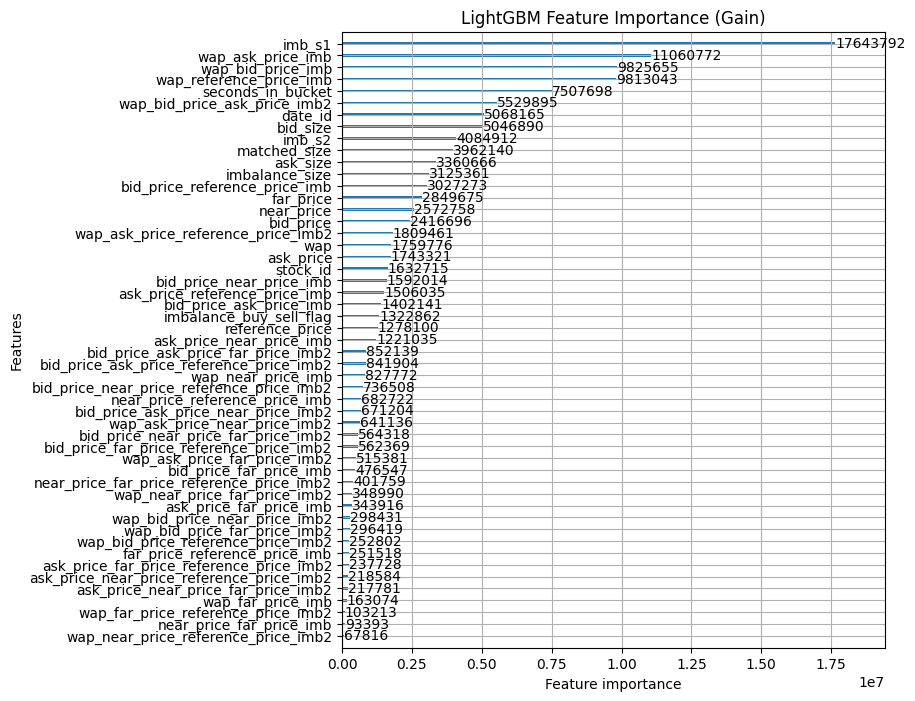

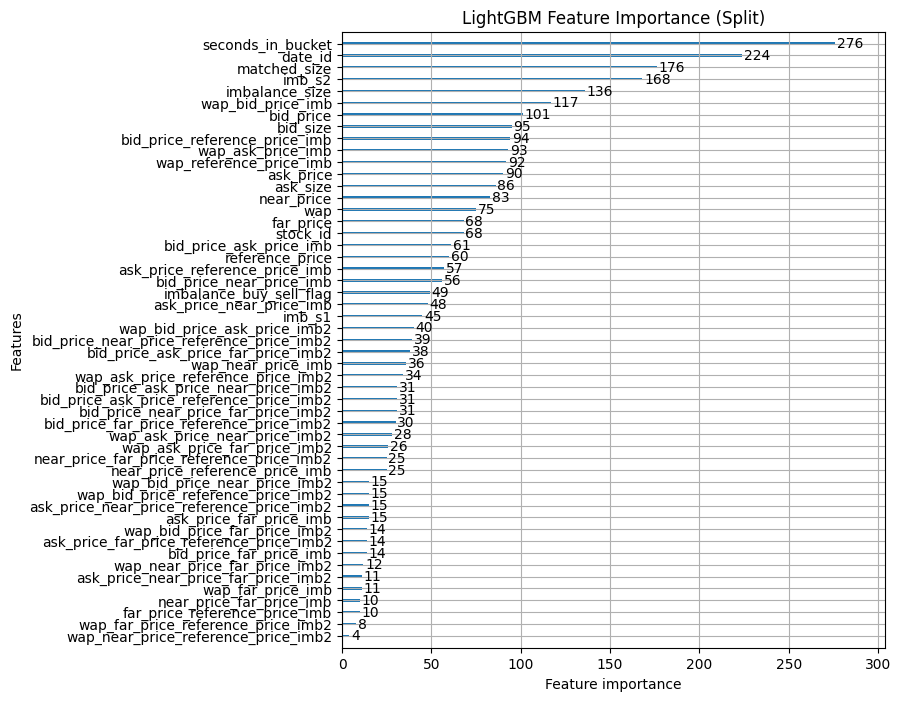

In [10]:
start = time.time()

# This will take longer, about 325s
X, y = read_data_feature_engineering(data_path, apply_derivative=False, derivative_targets=[
                                     'reference_price'], apply_imb=True)

# with derivative targets, warning, this could take about 10-15 minutes
# X, y = read_data_feature_engineering(data_path, apply_derivative=True, derivative_targets=[
#                                     'reference_price'], apply_imb=True)
lightGBM_model = LGBMRegressor(
    random_state=seed,
    # mse was used as it was found to perform better compared to objective function of 'mae
    objective='mse',
    device_type='gpu',  # You can switch to cpu
    # <0 to show only Fatal msg, 0 for Error(Warning), 1 for info, > 1 for Debug
    verbosity=0
)

best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    label='LightGBM_feature_2'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')
# Dont forget to take a look at the feature importance
plot_feature_importance(best_model)

 Part2 - Fourth run, try two model. Note this function is slightly different compared to the results

 in the report, for the report, model_wap and model_idx are trained together with same training data,
 and then used to predict the outcome of validation set. For submission, the whole training set is used to train
 both model

 In this approach, the original data is first split into training & testing set.
 The training set is further split into kfold (10), and used to train and find the best
 model_wap and model_idx separately.
 Then the best model_wap and model_idx are used to predict the target in the testing set.

 First define the functions required

In [11]:
def process_target(data):
    """process the data to compute target_wap and target_index

    Args:
        data (dataframe): raw data to be processed

    Returns:
        dataframe: processed data
    """

    data.sort_values(by=['stock_id', 'time_id'], inplace=True)
    data['target_wap'] = data['wap'].shift(6) / data['wap'] * 10000
    data['target_wap'] = data.apply(lambda x: x['target_wap'] if
                                    x['seconds_in_bucket'] <= 480 else None,  axis=1)
    data['target_index'] = data.apply(lambda x: x['target_wap'] - x['target'] if
                                      x['seconds_in_bucket'] <= 480 else None, axis=1)
    # Check if data processed correctly
    data.info()
    data.head(10)
    data.tail(10)
    data.dropna(subset=['target_wap', 'target_index'], inplace=True)
    data.sort_values(by=['time_id', 'stock_id'], inplace=True)
    return data


def read_data_2model(data_path: str, apply_imb=False):
    """Read the data from the train csv files, split them into the training and testing set
    # For training, computed the target_wap and target_idx

    Args:
        data_path (str): absolute save path for the train and test data set 
        apply_imb (bool, optional) : whether to apply the imbalance factor, default is false

    Returns:
        X (dataframe): Independent features for training
        y (dataframe): dependent features for training  
        y_wap (dataframe): dependent features for training  
        y_index (dataframe): dependent features for training  
        X_test (dataframe): independent features for testing 
        y_test (dataframe): dependentt features for testing 
    """
    # Load data from the save path
    data = pd.read_csv(f'{data_path}/train.csv',
                       dtype=dtypes).drop(['row_id'], axis=1)
    data.dropna(subset=['target'], inplace=True)
    if apply_imb:
        data = imbalance_calculator(data)

    # Split into train and test set
    from sklearn.model_selection import train_test_split
    train, X_test = train_test_split(
        data, test_size=0.1, train_size=0.9, shuffle=False)

    # Process the test set
    X_test.drop('time_id', axis=1, inplace=True)
    print("preview test set")
    X_test.info()
    print(X_test.head())
    print(X_test.isna().sum())
    y_test = X_test.pop('target')

    # Check the training data set
    print("\n\npreview data set")
    train.info()
    print(train.head())
    gc.collect()

    # preprocess data for two additional targets and split data into X and y
    X = process_target(train)
    X.drop('time_id', axis=1, inplace=True)

    # Check if data sorted correctly back
    print("data after processing")
    X.info()
    print(X.head())
    print(X.tail())
    y = X.pop('target')
    y_wap = X.pop('target_wap')
    y_index = X.pop('target_index')

    return X, y, y_wap, y_index, X_test, y_test

 Now running the process. First get the data, should take about 60-70s

preview test set
<class 'pandas.core.frame.DataFrame'>
Index: 523790 entries, 4714189 to 5237979
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   stock_id                 523790 non-null  uint8  
 1   date_id                  523790 non-null  uint16 
 2   seconds_in_bucket        523790 non-null  uint16 
 3   imbalance_size           523736 non-null  float64
 4   imbalance_buy_sell_flag  523790 non-null  int8   
 5   reference_price          523736 non-null  float64
 6   matched_size             523736 non-null  float64
 7   far_price                235633 non-null  float64
 8   near_price               239975 non-null  float64
 9   bid_price                523736 non-null  float64
 10  bid_size                 523790 non-null  float64
 11  ask_price                523736 non-null  float64
 12  ask_size                 523790 non-null  float64
 13  wap                      523736 non-null

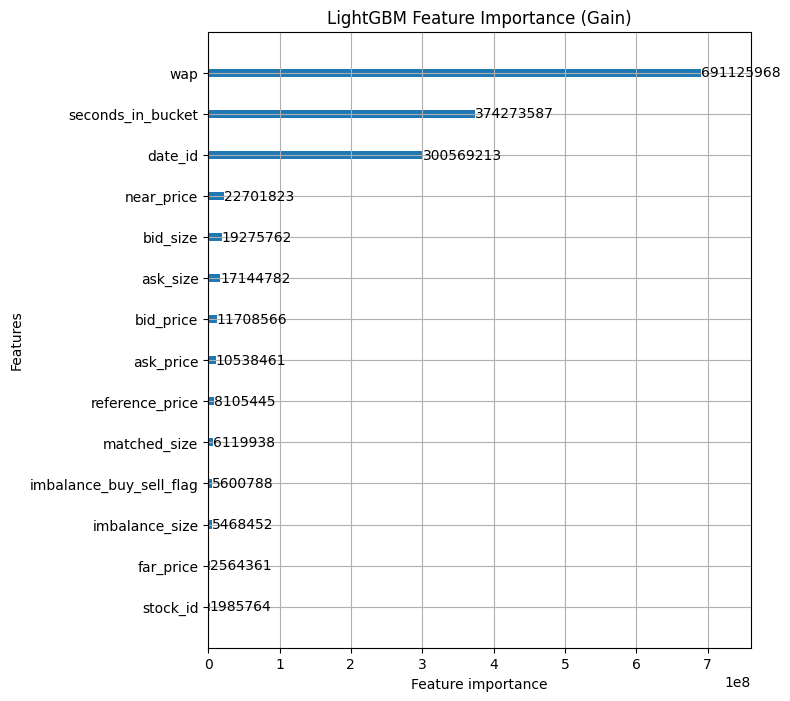

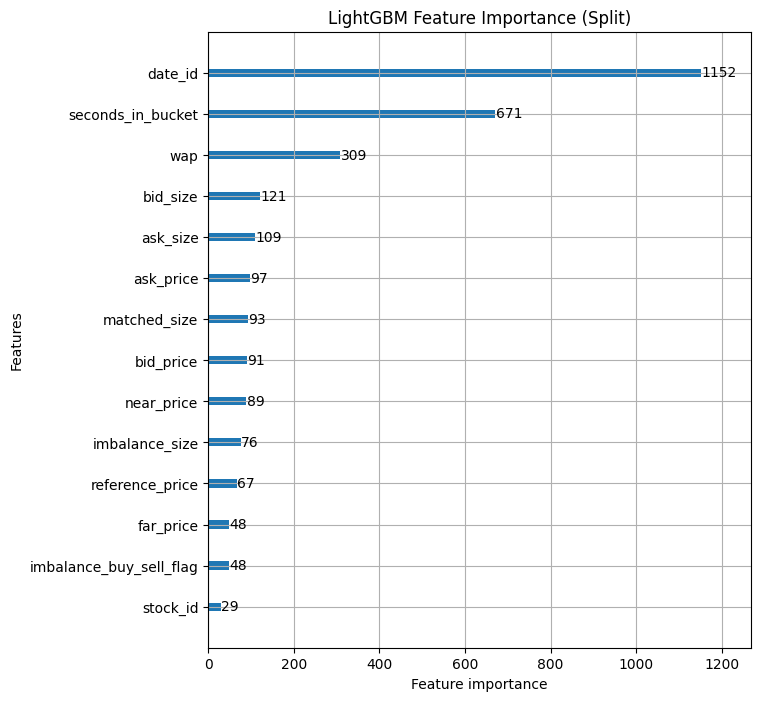


Feature importance for model idx
LGBMRegressor(device_type='gpu', objective='mse', random_state=42, verbosity=0)


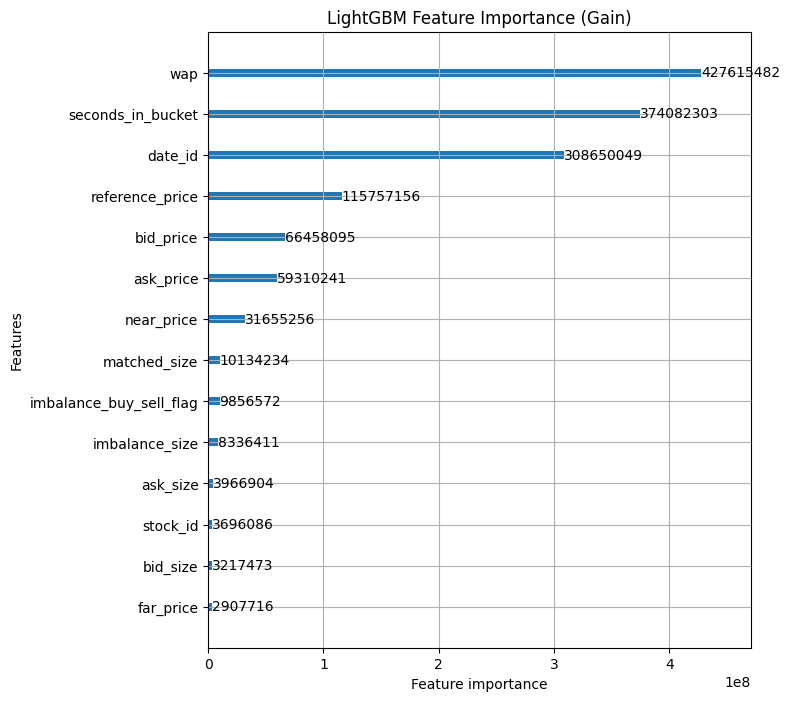

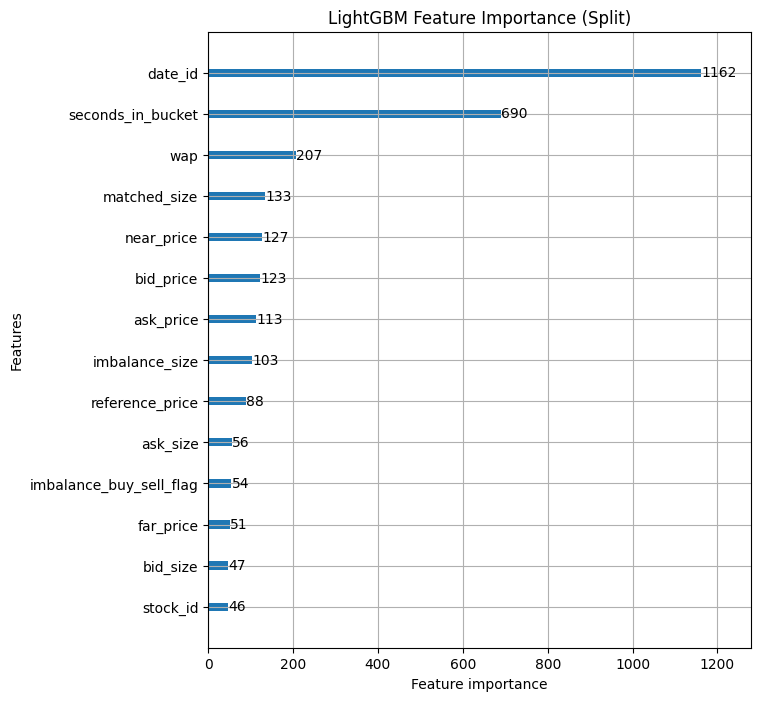

In [12]:
start = time.time()
X, y, y_wap, y_index, X_test, y_test = read_data_2model(data_path)

# Can also switch to apply imb features, training took longer
# X, y, y_wap, y_index, X_test, y_test = read_data_2model(
#    data_path, apply_imb=True)

end = time.time()
print(f'Data processing time took = {(end - start):.0f} seconds')
start = end

# Train and get the best model_wap overall will took about 220 s
print('\ntraining model_wap')
model_wap = LGBMRegressor(
    random_state=seed, objective='mse', device_type='gpu',  verbosity=0)
best_model_wap = cross_validation(model_wap, X, y_wap, label='modelwap')

# Train and get the best model_idx
print('\ntraining model_idx')
model_idx = LGBMRegressor(
    random_state=seed, objective='mse', device_type='gpu', verbosity=0)
best_model_idx = cross_validation(model_idx, X, y_index, label='modelidx')

test_wap_preds = best_model_wap.predict(X_test)
test_idx_preds = best_model_idx.predict(X_test)
test_target_preds = test_wap_preds - test_idx_preds

test_score = mean_absolute_error(y_test, test_target_preds)

end = time.time()
print(f'Training and testing time took = {(end - start):.0f} seconds')
print(f'MAE for two model approach is {test_score}')

# Dont forget to check the feature importance. You can also see the correlation in the EDA
print("\nFeature importance for model wap")
plot_feature_importance(best_model_wap)
print("\nFeature importance for model idx")
plot_feature_importance(best_model_idx)

 Part3 - hyperparameter tuning

 This will set the Optuna objective function
 Set the objective function for Optuna study and running trials

In [13]:
def objective(trial, X, y):
    """objective function for optina

    Args:
        trial (func): represent a trial
        X (dataframe): independent variables
        y (dataframe): dependent variable

    Returns:
        float: objective score
    """
    max_depth = trial.suggest_int("max_depth", 4, 12)
    param_grid = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": max_depth,
        "num_leaves": trial.suggest_int("num_leaves", 2**(max_depth-1), 2**(max_depth), step=2**(max_depth-1)//8),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100, 10000, step=100),
        "max_bin": trial.suggest_int("max_bin", 32, 256),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1)
    }
    cv = KFold(n_splits=5
               )
    cv_scores = np.empty(10)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        # define train set
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]

        # define validation set
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model = LGBMRegressor(random_state=seed, objective='mse',
                              device_type='gpu', verbosity=-1, early_stopping_rounds=50, **param_grid)
        # train model
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],  callbacks=[
                  LightGBMPruningCallback(trial, 'l2')])
        val_preds = model.predict(X_val)

        # evaluate model for a fold
        val_score = mean_absolute_error(y_val, val_preds)
        cv_scores[fold] = val_score
    return np.mean(cv_scores)

 Read the data and Run the optuna function. warning, this could take very long
 To show the function is working, I set the n_trials value to a low value
 early_stopping_rounds to 50, cross validation fold for objective function to 5 instead 10.
 In actual i use a larger value for better result. This should take about 20 minutes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 uint8  
 1   date_id                  uint16 
 2   seconds_in_bucket        uint16 
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int8   
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
dtypes: float64(11), int8(1), uint16(2), uint8(1)
memory usage: 469.6 MB
   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       1666

[I 2023-12-17 15:42:32,038] A new study created in memory with name: LGBM Regressor


<class 'pandas.core.frame.DataFrame'>
Index: 5237892 entries, 0 to 5237979
Data columns (total 51 columns):
 #   Column                                     Dtype  
---  ------                                     -----  
 0   stock_id                                   uint8  
 1   date_id                                    uint16 
 2   seconds_in_bucket                          uint16 
 3   imbalance_size                             float64
 4   imbalance_buy_sell_flag                    int8   
 5   reference_price                            float64
 6   matched_size                               float64
 7   far_price                                  float64
 8   near_price                                 float64
 9   bid_price                                  float64
 10  bid_size                                   float64
 11  ask_price                                  float64
 12  ask_size                                   float64
 13  wap                                        floa

c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
c:\Users\jinqw\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\trial\_trial.py:494: UserWarning: The reported value is ignored because this `step` 4 is already reporte

training time took = 1123 seconds
	Best value (mse): 3.13944
	Best params:
		max_depth: 11
		n_estimators: 250
		learning_rate: 0.01989106480320907
		num_leaves: 1664
		min_data_in_leaf: 4700
		max_bin: 169
		min_gain_to_split: 14.432656089091964
		subsample: 0.7540297109080402


<ipython-input-14-832771eaa34f>:19: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

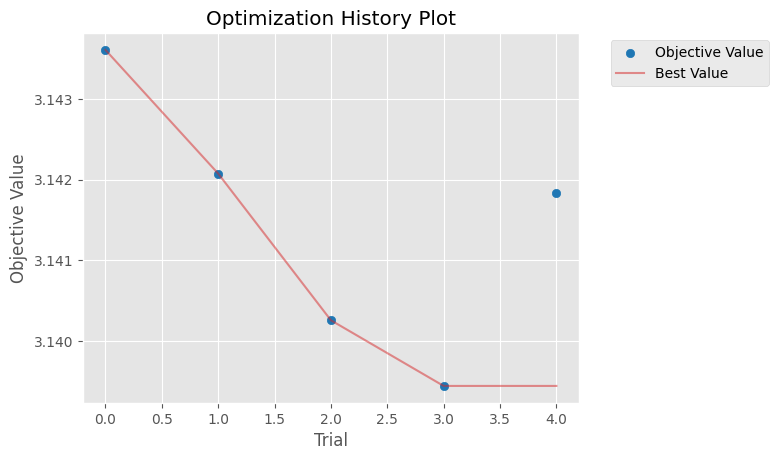

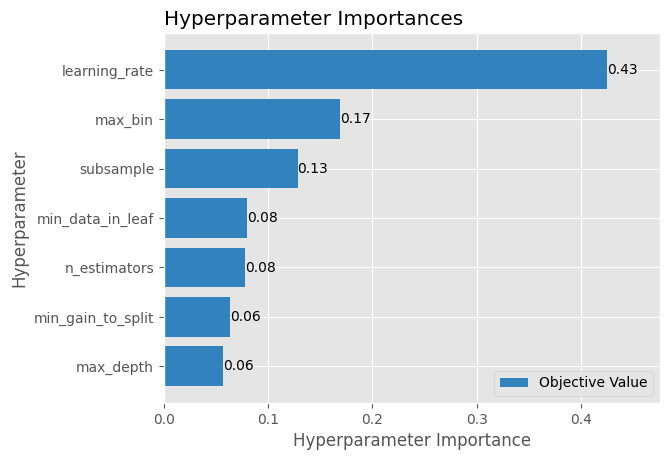

In [14]:
start = time.time()
X, y = read_data_feature_engineering(data_path, apply_derivative=False, derivative_targets=[
                                     'reference_price'], apply_imb=True)
study = optuna.create_study(direction='minimize', study_name='LGBM Regressor')
def func(trial): return objective(trial, X, y)


study.optimize(func, n_trials=5)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

# Check the optimization history and param_importances
print(f"\tBest value (mse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")
plot_optimization_history(study)
plot_param_importances(study)

 Rerun the training using best hyperparameter obtained, could take very long (like 30 minutes as well)

In [15]:
lightGBM_model = LGBMRegressor(random_state=seed, objective='mse',
                               device_type='gpu', verbosity=-1, **study.best_params)
start = time.time()
best_model = cross_validation(
    model=lightGBM_model,
    X=X,
    y=y,
    cv=kf,
    label='LightGBM_feature_2'
)
end = time.time()
print(f'training time took = {(end - start):.0f} seconds')

Val Score: 6.27465 ± 0.54772 | Train Score: 6.25188 ± 0.06049 | LightGBM_feature_2
fold:0, Val Score: 5.183765848609734, Train Score: 6.372791965692182
fold:1, Val Score: 6.244449979038073, Train Score: 6.253800198393637
fold:2, Val Score: 7.179134166421741, Train Score: 6.153463687171394
fold:3, Val Score: 6.921801858897399, Train Score: 6.179464352372513
fold:4, Val Score: 6.744465450837843, Train Score: 6.199764343025697
fold:5, Val Score: 5.92172611213203, Train Score: 6.2914519172568335
fold:6, Val Score: 6.348374495352095, Train Score: 6.243055195792876
fold:7, Val Score: 6.2985537976092445, Train Score: 6.249710679954564
fold:8, Val Score: 6.032269945604005, Train Score: 6.280225144386314
fold:9, Val Score: 5.871985236994517, Train Score: 6.295066280292124
Best validation score: 5.183765848609734, associated train score: 6.372791965692182, fold:0
training time took = 1177 seconds
